# Download dataset

In [ ]:
! pip install kaggle

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d paultimothymooney/blood-cells
!unzip /content/blood-cells.zip -d /content/output

Streaming output truncated to the last 5000 lines.
  inflating: /content/output/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8050.jpeg  
  inflating: /content/output/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8167.jpeg  
  inflating: /content/output/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8283.jpeg  
  inflating: /content/output/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8324.jpeg  
  inflating: /content/output/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8379.jpeg  
  inflating: /content/output/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8577.jpeg  
  inflating: /content/output/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8587.jpeg  
  inflating: /content/output/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8655.jpeg  
  inflating: /content/output/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8701.jpeg  
  inflating: /content/output/dataset2-master/data

# Load Data

In [ ]:
import numpy as np
import os
import cv2
import csv
from glob import glob
import pathlib
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_path = pathlib.Path("/content/output/dataset2-master/dataset2-master/images/TRAIN")

In [ ]:
training_set = list(train_path.glob('*/*.jpeg'))
print(f"Number of Training samples: {len(training_set)}")

Number of Training samples: 9957


In [ ]:
class_names = os.listdir(train_path)
class_names

['NEUTROPHIL', 'MONOCYTE', 'EOSINOPHIL', 'LYMPHOCYTE']

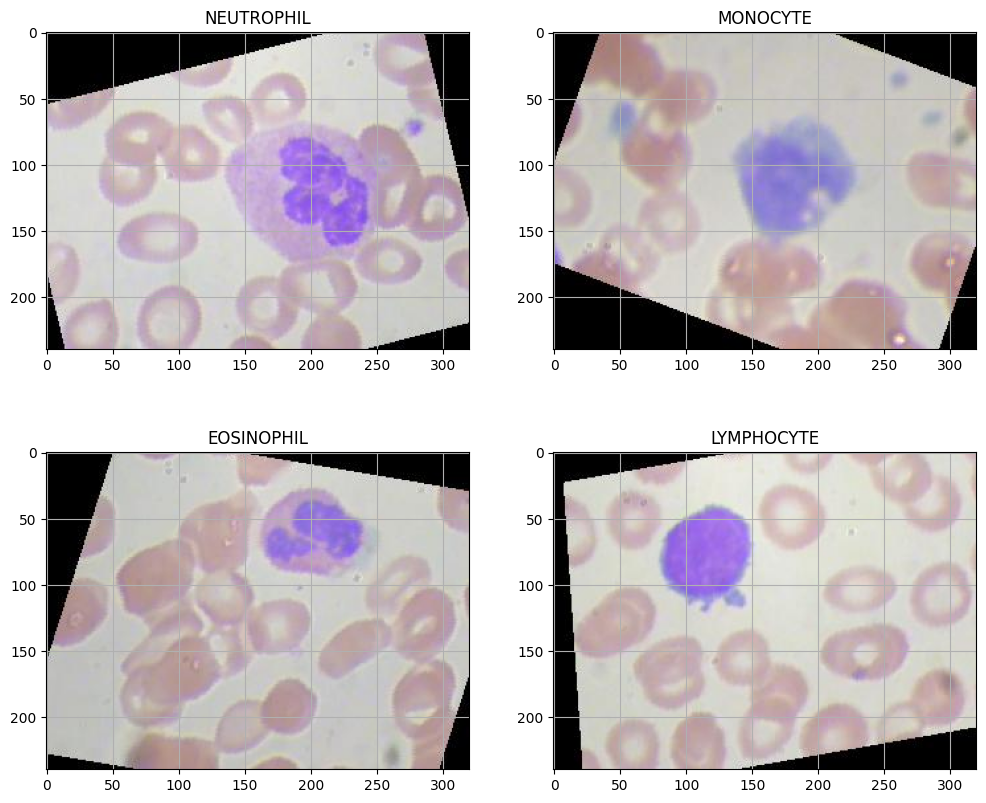

In [ ]:
def plotImage(image_path):
    image = cv2.imread(image_path)
    image = image[:, :, [2, 1, 0]]
    plt.imshow(image)
    return

plt.figure(figsize=(12,10))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plotImage(str(list(train_path.glob(class_names[i]+'/*.jpeg'))[0]))
    plt.title(class_names[i])
    plt.grid()

# Data Prepare

In [ ]:
plt.imread(str(list(train_path.glob('LYMPHOCYTE/*.jpeg'))[0])).shape

(240, 320, 3)

In [ ]:
# resize image
height = 120
width = 120

In [ ]:
file_locations = defaultdict(list)

for folder in train_path.iterdir():
    if folder.is_dir():
        for file in folder.iterdir():
            if file.is_file():
                file_locations[file.name].append(folder.name)

for file_name, folders in file_locations.items():
    if len(folders) > 1:
        print(f"File '{file_name}' appears in multiple directories：{', '.join(folders)}")

File '_2_8351.jpeg' appears in multiple directories：NEUTROPHIL, LYMPHOCYTE
File '_9_5125.jpeg' appears in multiple directories：NEUTROPHIL, EOSINOPHIL
File '_9_8636.jpeg' appears in multiple directories：NEUTROPHIL, EOSINOPHIL
File '_22_9328.jpeg' appears in multiple directories：NEUTROPHIL, LYMPHOCYTE
File '_20_8872.jpeg' appears in multiple directories：NEUTROPHIL, LYMPHOCYTE
File '_14_561.jpeg' appears in multiple directories：NEUTROPHIL, LYMPHOCYTE
File '_74_5758.jpeg' appears in multiple directories：NEUTROPHIL, EOSINOPHIL
File '_31_2622.jpeg' appears in multiple directories：NEUTROPHIL, EOSINOPHIL
File '_15_5256.jpeg' appears in multiple directories：NEUTROPHIL, MONOCYTE
File '_3_7899.jpeg' appears in multiple directories：NEUTROPHIL, MONOCYTE
File '_9_7478.jpeg' appears in multiple directories：NEUTROPHIL, MONOCYTE
File '_20_3960.jpeg' appears in multiple directories：NEUTROPHIL, LYMPHOCYTE
File '_1_5481.jpeg' appears in multiple directories：NEUTROPHIL, LYMPHOCYTE
File '_15_8510.jpeg' appe

In [ ]:
# Create a csv file to store training image name and its label(s)
train_data = []
for label_dir in train_path.iterdir():
    if label_dir.is_dir():
        for image_path in label_dir.iterdir():
            if image_path.is_file():
                train_data.append({"filepath": str(train_path) + "/" + label_dir.name + "/" + image_path.name, "labels": label_dir.name})

df = pd.DataFrame(train_data)
df_grouped = df.groupby("filepath")["labels"].apply(lambda x: ",".join(x)).reset_index()
training_csv = "/content/training_set_labels.csv"

In [ ]:
df_grouped.to_csv(training_csv, index=False)

In [ ]:
df = pd.read_csv(training_csv)

print(df.head())
print(df["labels"].value_counts())
print(df.shape)

                                            filepath      labels
0  /content/output/dataset2-master/dataset2-maste...  EOSINOPHIL
1  /content/output/dataset2-master/dataset2-maste...  EOSINOPHIL
2  /content/output/dataset2-master/dataset2-maste...  EOSINOPHIL
3  /content/output/dataset2-master/dataset2-maste...  EOSINOPHIL
4  /content/output/dataset2-master/dataset2-maste...  EOSINOPHIL
NEUTROPHIL    2499
EOSINOPHIL    2497
LYMPHOCYTE    2483
MONOCYTE      2478
Name: labels, dtype: int64
(9957, 2)


In [ ]:
# split data for training, validation, testing
train_images, test_images = train_test_split(df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
image_generator = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train_data = image_generator.flow_from_dataframe(dataframe= train_set,x_col="filepath",y_col="labels",
                                      target_size=(height, width),
                                      color_mode='rgb',
                                      class_mode="categorical",
                                      batch_size=8,
                                      shuffle=False
                                     )
test_data = image_generator.flow_from_dataframe(dataframe= test_images,x_col="filepath", y_col="labels",
                                     target_size=(height, width),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=8,
                                     shuffle= False
                                    )
validation_data = image_generator.flow_from_dataframe(dataframe= val_set,x_col="filepath", y_col="labels",
                                    target_size=(height, width),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=8,
                                    shuffle=False
                                   )

Found 7965 validated image filenames belonging to 4 classes.
Found 2988 validated image filenames belonging to 4 classes.
Found 1992 validated image filenames belonging to 4 classes.


# Create model

In [ ]:
def build_model(optimizer, learning_rate, num_layers, dropout_rate):
    model = Sequential()
    model.add(Conv2D(filters=256, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(height, width, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((3, 3)))
    model.add(BatchNormalization())
    for _ in range(1, num_layers):
        model.add(Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((1, 1)))
        model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))

    if optimizer == 'Adam':
        opt = Adam(learning_rate=learning_rate)
    else:
        opt = SGD(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'num_layers': [4, 3, 2],
    'dropout_rate': [0.5, 0.2],
    'optimizer': ['SGD', 'adam']
}

# Tune hyperparameters


In [ ]:
results = []

for optimizer in param_grid['optimizer']:
    for learning_rate in param_grid['learning_rate']:
        for num_layers in param_grid['num_layers']:
            for dropout_rate in param_grid['dropout_rate']:
                print(
                    f"train: optimizer={optimizer}, learning_rate={learning_rate}, num_layers={num_layers}, dropout_rate={dropout_rate}")

                model = build_model(optimizer=optimizer, learning_rate=learning_rate, num_layers=num_layers,
                                    dropout_rate=dropout_rate)

                history = model.fit(train_data, epochs=10, validation_data=validation_data, verbose=1)

                best_val_acc = max(history.history['val_accuracy'])
                print(f"Finish training: best_val_acc = {best_val_acc}")
                results.append((optimizer, learning_rate, num_layers, dropout_rate, best_val_acc))


train: optimizer=SGD, learning_rate=0.001, num_layers=4, dropout_rate=0.5
Epoch 1/10
996/996 [==============================] - 30s 23ms/step - loss: 1.7239 - accuracy: 0.3460 - val_loss: 1.1577 - val_accuracy: 0.4689
Epoch 2/10
996/996 [==============================] - 23s 23ms/step - loss: 1.1835 - accuracy: 0.4989 - val_loss: 0.8476 - val_accuracy: 0.6300
Epoch 3/10
996/996 [==============================] - 22s 22ms/step - loss: 0.9251 - accuracy: 0.6010 - val_loss: 0.7108 - val_accuracy: 0.7003
Epoch 4/10
996/996 [==============================] - 22s 22ms/step - loss: 0.7321 - accuracy: 0.6899 - val_loss: 0.7031 - val_accuracy: 0.6953
Epoch 5/10
996/996 [==============================] - 22s 22ms/step - loss: 0.5999 - accuracy: 0.7561 - val_loss: 0.5445 - val_accuracy: 0.7605
Epoch 6/10
996/996 [==============================] - 26s 26ms/step - loss: 0.4644 - accuracy: 0.8097 - val_loss: 0.4569 - val_accuracy: 0.8017
Epoch 7/10
842/996 [========================>.....] - ETA: 3s 

KeyboardInterrupt: 

# Result

In [ ]:
best_run = sorted(results, key=lambda x: x[-1], reverse=True)[0]
print("best model：", best_run)

In [ ]:
model = build_model(optimizer=best_run[0],
                    learning_rate=best_run[1],
                    num_layers=best_run[2],
                    dropout_rate=best_run[3])

In [ ]:
model.summary()

In [ ]:
history = model.fit(train_data, epochs=10, validation_data=validation_data, verbose=1)

In [ ]:
history1 = model.fit(train_data, epochs=1, validation_data=validation_data, verbose=1)

In [ ]:
model.evaluate(test_data, verbose=1)

In [ ]:
prediction = model.predict(test_data)
prediction = np.argmax(prediction, axis=1)

labels = train_data.class_indices
labels = dict((v,k) for k,v in labels.items())
prediction2 = [labels[k] for k in prediction]

In [ ]:
plt.plot(history.history['accuracy'] + history1.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'] + history1.history['loss'])
plt.plot(history.history['val_loss'] + history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_test = test_images.labels
print(classification_report(y_test, prediction2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, prediction2)*100))